In [2]:
# Essential ASE imports
from ase import Atoms
from ase.io import Trajectory, read, write
from ase.io.vasp import read_vasp
from ase.constraints import FixAtoms
from ase.optimize import LBFGS
from ase.constraints import ExpCellFilter, StrainFilter

# PFP API imports
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode, EstimatorMethodType

# Other essential imports
import numpy as np
import os
import shutil
import subprocess
from collections import Counter
from PIL import Image
from pymatgen.core.surface import SlabGenerator
from pymatgen.io.ase import AseAtomsAdaptor
import random
import subprocess

def visual2(structure,title,  max_size=(100, 100), rotation='15z,-90x',celloff=True):
    def calculate_stretch_factor(cell):
        """Calculate the stretch factor for visualization based on the cell dimensions."""
        x_length = cell[0][0]
        y_length = cell[1][1]

        # Avoid division by zero
        if y_length == 0:
            return 1.0

        stretch_y = y_length / x_length
        return stretch_y

    # Calculate stretch factor based on the structure's cell
    stretch_y = calculate_stretch_factor(structure.cell)
    temp=structure.copy()
    if celloff==True:
      temp.cell = None
    # Visualize the structure
    renderer = write('./temp.pov', temp, rotation=rotation)
    renderer.render()
    image_path = f'./temp.png'
    img = Image.open(image_path)

    # Calculate new size with stretch factor
    new_size = (max_size[0], int(max_size[1] * stretch_y))
    img = img.resize(new_size, Image.LANCZOS)
    img.info['dpi'] = 2000
    display(img)

    # Move files to output directory
    destination = './output/'
    files = ['./temp.ini', './temp.pov', './temp.png']

    # Ensure destination directory exists
    os.makedirs(destination, exist_ok=True)

    for file in files:
        # Remove the file in the destination directory if it exists
        if os.path.isfile(os.path.join(destination, os.path.basename(file))):
            os.remove(os.path.join(destination, os.path.basename(file)))

        shutil.move(file, destination)
    original_image_path = os.path.join(destination, 'temp.png')
    new_image_path = os.path.join(destination, f'{title}.png')

    # Rename the image file
    os.rename(original_image_path, new_image_path)
    
#############################Calculator setting###################################
calc_mode="CRYSTAL" # including +U correction
model_version="v4.0.0"  # the latest model version
method_type=EstimatorMethodType.PFVM
estimator = Estimator(calc_mode=calc_mode, model_version=model_version, method_type=method_type)
calculator = ASECalculator(estimator)
##################################################################################

def get_opt_energy(atoms, fmax=0.05, opt_mode: str = "normal"):    
    atoms.set_calculator(calculator)
    if opt_mode == "scale":
        opt1 = LBFGS(StrainFilter(atoms, mask=[1, 1, 1, 0, 0, 0]))
    elif opt_mode == "all":
        opt1 = LBFGS(ExpCellFilter(atoms))
    else:
        opt1 = LBFGS(atoms)
    opt1.run(fmax=fmax)
    return atoms.get_total_energy()

/home/jovyan/.py38/lib/python3.8/site-packages/pfp_api_client/__init__.py:35: UserWarning: New version of pfp-api-client is available. Please consider upgrading by `pip install -U pfp-api-client`.
  warnings.warn(


In [13]:
rod = read_vasp("../1_structure_gen/output/rod_relaxed.vasp")
write('rod.pdb',rod)
cube = read_vasp("../1_structure_gen/output/best_2_8_cubes_stoi.vasp")
write('cube.pdb',cube)

### packmol Automation

In [19]:


def generate_inp_file(rand_num, output_dir,structure_file, co_structure, fixed_values=(28., 28., 4., 0., 0., 0.), box_dimensions=(2., 2., 4., 53., 53., 50.)):
    content = f"""

tolerance 2
filetype pdb
seed -1

output ./{rand_num}.pdb
structure {structure_file}
  number 1
  center
  fixed {' '.join(map(str, fixed_values))}
end structure

structure {co_structure}
   number 100           
   inside box {' '.join(map(str, box_dimensions))}
end structure
"""
    file_name = f"./{output_dir}{rand_num}.inp"
    with open(file_name, 'w') as file:
        file.write(content.strip())
    return file_name

def run_packmol(input_file):
    # Extract the directory from the input file path
    input_dir = os.path.dirname(input_file)

    # Form the command to change the directory and run Packmol
    command = f"cd {input_dir} && ~/packmol-20.14.0/packmol < {os.path.basename(input_file)}"
    
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode == 0:
        print(f"Packmol ran successfully for {input_file}")
    else:
        print(f"Packmol encountered an error for {input_file}: {result.stderr}")
        
        
output_dir="1_co_env_rand_input/inp_files/" # directory for input files
structure_file="../../rod.pdb" # directory for input files
co_structure='../../../packmol_center/co.pdb' # directory for input files
for i in range(10):  # Generate 10 .inp files
    rand_num = i 
    file_name=generate_inp_file(rand_num,output_dir,structure_file,co_structure)
    run_packmol(file_name)


Packmol ran successfully for ./1_co_env_rand_input/inp_files/0.inp
Packmol ran successfully for ./1_co_env_rand_input/inp_files/1.inp
Packmol ran successfully for ./1_co_env_rand_input/inp_files/2.inp
Packmol ran successfully for ./1_co_env_rand_input/inp_files/3.inp
Packmol ran successfully for ./1_co_env_rand_input/inp_files/4.inp
Packmol ran successfully for ./1_co_env_rand_input/inp_files/5.inp
Packmol ran successfully for ./1_co_env_rand_input/inp_files/6.inp
Packmol ran successfully for ./1_co_env_rand_input/inp_files/7.inp
Packmol ran successfully for ./1_co_env_rand_input/inp_files/8.inp
Packmol ran successfully for ./1_co_env_rand_input/inp_files/9.inp


In [20]:
def generate_inp_file_cube(rand_num, output_dir,structure_file, co_structure, fixed_values, box_dimensions=(2., 2., 2., 53., 53., 50.)):
    content = f"""

tolerance 2
filetype pdb
seed -1

output ./{rand_num}_cube.pdb
structure {structure_file}
  number 1
  center
  fixed {' '.join(map(str, fixed_values))}
end structure

structure {co_structure}
   number 100           
   inside box {' '.join(map(str, box_dimensions))}
end structure
"""
    file_name = f"./{output_dir}{rand_num}_cube.inp"
    with open(file_name, 'w') as file:
        file.write(content.strip())
    return file_name

output_dir="1_co_env_rand_input/inp_files/"
structure_file="../../cube.pdb"
co_structure='../../../packmol_center/co.pdb'
fixed_values=(28., 28., 25., 0., 0., 0.)
for i in range(10):  # Generate 10 .inp files
    rand_num = i 
    file_name=generate_inp_file_cube(rand_num,output_dir,structure_file,co_structure,fixed_values)
    run_packmol(file_name)


Packmol ran successfully for ./1_co_env_rand_input/inp_files/0_cube.inp
Packmol ran successfully for ./1_co_env_rand_input/inp_files/1_cube.inp
Packmol ran successfully for ./1_co_env_rand_input/inp_files/2_cube.inp
Packmol ran successfully for ./1_co_env_rand_input/inp_files/3_cube.inp
Packmol ran successfully for ./1_co_env_rand_input/inp_files/4_cube.inp
Packmol ran successfully for ./1_co_env_rand_input/inp_files/5_cube.inp
Packmol ran successfully for ./1_co_env_rand_input/inp_files/6_cube.inp
Packmol ran successfully for ./1_co_env_rand_input/inp_files/7_cube.inp
Packmol ran successfully for ./1_co_env_rand_input/inp_files/8_cube.inp
Packmol ran successfully for ./1_co_env_rand_input/inp_files/9_cube.inp


In [21]:
from pymatgen.core.surface import SlabGenerator
from pymatgen.io.ase import AseAtomsAdaptor
from ase.build import make_supercell
import numpy as np
from collections import Counter
from scipy.spatial import distance

def pbc_cell(atoms,rod):
    temp=atoms.copy()
    temp.cell= rod.cell
    temp.pbc= True
    return temp

def fix_atoms(atoms,rod):
    temp=atoms.copy()
    temp.pbc= True
    temp.set_pbc((True, True, True))
    temp.cell=rod.cell
    ce_positions = np.array([temp.position for temp in temp if temp.symbol == 'Ce'])
    ce_median_z = np.median(ce_positions[:, 2])
    mask = temp.positions[:, 2] < ce_median_z
    c = FixAtoms(mask=mask)
    temp.set_constraint(c)
    num_constrained_atoms = np.sum(mask)
    print("how many fixed atoms:", num_constrained_atoms, "out of", temp.get_global_number_of_atoms())
    print(temp.cell)
    return temp

def print_slab_info(atoms):
    ce_positions = np.array([atom.position for atom in atoms if atom.symbol == 'Ce'])
    ce_min_z, ce_max_z = np.min(ce_positions[:, 2]), np.max(ce_positions[:, 2])
    ce_min_y, ce_max_y = np.min(ce_positions[:, 1]), np.max(ce_positions[:, 1])
    ce_min_x, ce_max_x = np.min(ce_positions[:, 0]), np.max(ce_positions[:, 0])
    size_x = round(ce_max_x-ce_min_x, 3)
    size_y = round(ce_max_y-ce_min_y, 3)
    size_z = round(ce_max_z-ce_min_z,3)
    print(f"length and width : {size_x} A x {size_y} x {size_z}  A")
    print(f"N_atoms: {len(atoms)}")
    symbols = atoms.get_chemical_symbols()
    element_counts = Counter(symbols)
    element_counts_line = ', '.join(f"{element}: {count}" for element, count in element_counts.items())
    print(f"Composition: {element_counts_line}")
    print("===============================")


def generate_slab(bulk, miller_index, supercell_dimensions,thick,fixoff=False):
    bulk_temp=bulk.copy()
    slab_gen = SlabGenerator(
        initial_structure=AseAtomsAdaptor.get_structure(bulk_temp),
        miller_index=miller_index,
        min_slab_size=thick,
        min_vacuum_size=40.0,
        lll_reduce=False,
        center_slab=True,
        primitive=True,
        max_normal_search=1,
    )
    
    slabs = slab_gen.get_slabs(tol=0.3, bonds=None, max_broken_bonds=0, symmetrize=False)
    slab_atoms_list = [AseAtomsAdaptor.get_atoms(slab) for slab in slabs]
    print('N termination:',len(slab_atoms_list))
    slab = slab_atoms_list[0].copy()
    slab = slab * supercell_dimensions
    
    # Shift `slab` to the bottom of the cell
    min_pos_z = np.min(slab.positions, axis=0)[2]
    slab.set_positions(slab.positions - [0, 0, min_pos_z])
    temp = slab.copy()
    if fixoff==False:
        temp = fix_atoms(temp)
        
    return temp


In [22]:
rod_list=[]
cube_list=[]

for i in range(10):  # Generate 10 .inp files
    rand_num = i 
    pdb_file=read(f'./1_co_env_rand_input/inp_files/{i}_cube.pdb')
    pdb_file_rod=read(f'./1_co_env_rand_input/inp_files/{i}.pdb')
    pdb_file_rod=fix_atoms(pdb_file_rod,rod)
    pdb_file=pbc_cell(pdb_file,rod)
    cube_list.append(pdb_file)
    rod_list.append(pdb_file_rod)
write('rod_list_co_rand_10.traj',rod_list)
write('cube_list_co_rand_10.traj',cube_list)

how many fixed atoms: 840 out of 1880
Cell([[55.15350491259771, 0.0, 3.68022650161e-05], [4.22893922699e-05, 55.71345269068901, -1.78800894033e-05], [0.0, 0.0, 55.15350439280487]])
how many fixed atoms: 840 out of 1880
Cell([[55.15350491259771, 0.0, 3.68022650161e-05], [4.22893922699e-05, 55.71345269068901, -1.78800894033e-05], [0.0, 0.0, 55.15350439280487]])
how many fixed atoms: 840 out of 1880
Cell([[55.15350491259771, 0.0, 3.68022650161e-05], [4.22893922699e-05, 55.71345269068901, -1.78800894033e-05], [0.0, 0.0, 55.15350439280487]])
how many fixed atoms: 840 out of 1880
Cell([[55.15350491259771, 0.0, 3.68022650161e-05], [4.22893922699e-05, 55.71345269068901, -1.78800894033e-05], [0.0, 0.0, 55.15350439280487]])
how many fixed atoms: 840 out of 1880
Cell([[55.15350491259771, 0.0, 3.68022650161e-05], [4.22893922699e-05, 55.71345269068901, -1.78800894033e-05], [0.0, 0.0, 55.15350439280487]])
how many fixed atoms: 840 out of 1880
Cell([[55.15350491259771, 0.0, 3.68022650161e-05], [4.228

length and width : 29.668 A x 29.032 x 29.401  A
N_atoms: 2195
Composition: O: 1430, Ce: 665, C: 100


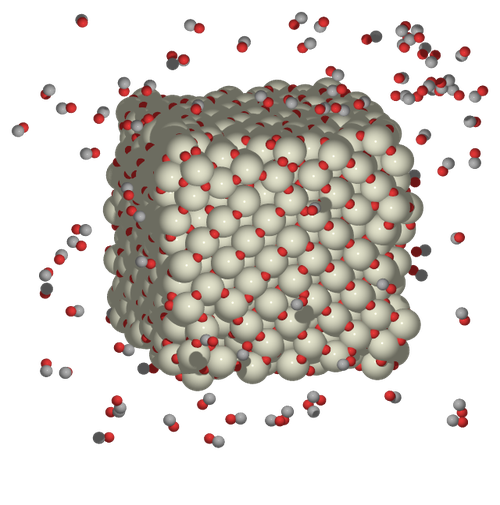

In [25]:
traj=Trajectory('./cube_list_co_rand_10.traj')
print_slab_info(traj[0])
traj[0]
visual2(traj[0], f'test', (500, 500), rotation='15z,-75x', celloff=True)